In [1]:
# simple EDA set up

In [2]:
pip install pretty_midi pandas matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import glob
import os
import pretty_midi


In [4]:
import glob, os, pprint

# get all files
root = "/home/s2kunapareddy/music/data/midi"
midi_files = glob.glob(os.path.join(root, "**", "*.midi"), recursive=True)

midi_files = [f for f in midi_files if os.path.isfile(f)]

print(f"Found {len(midi_files):,} MIDI files")
pprint.pp(midi_files[:5])     

Found 1,276 MIDI files
['/home/s2kunapareddy/music/data/midi/2013/ORIG-MIDI_01_7_10_13_Group_MID--AUDIO_07_R3_2013_wav--2.midi',
 '/home/s2kunapareddy/music/data/midi/2013/ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_02_R2_2013_wav--1.midi',
 '/home/s2kunapareddy/music/data/midi/2013/ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_02_R1_2013_wav--2.midi',
 '/home/s2kunapareddy/music/data/midi/2013/ORIG-MIDI_03_7_6_13_Group__MID--AUDIO_09_R1_2013_wav--3.midi',
 '/home/s2kunapareddy/music/data/midi/2013/ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_15_R1_2013_wav--4.midi']


Get midi features 

In [5]:
import pandas as pd
from tqdm import tqdm

rows = []
for path in tqdm(midi_files):
    try:
        pm = pretty_midi.PrettyMIDI(path)
        duration = pm.get_end_time()             # seconds
        n_notes  = sum(len(ins.notes) for ins in pm.instruments)
        tempo_changes, tempi = pm.get_tempo_changes()
        total_velocity = sum(sum(pm.get_chroma()))
        total_force = sum(n.velocity for ins in pm.instruments for n in ins.notes)
        tempo = pm.estimate_tempo()
        mean_tempo = tempi.mean() if len(tempi) else None
        pitches = [n.pitch for ins in pm.instruments for n in ins.notes]

        # duration of notes 
        note_durations = [n.end - n.start for ins in pm.instruments for n in ins.notes]

        # Onsets
        onsets = sorted(n.start for ins in pm.instruments for n in ins.notes)
        
        rows.append({
            "file": path,
            "total_velocity" : total_velocity,
            "duration_s": duration,
            "note_durations": note_durations,
            "onsets" : onsets, 
            "n_notes": n_notes,
            "total_force": total_force,
            "min_pitch": min(pitches) if pitches else None,
            "max_pitch": max(pitches) if pitches else None,
            "temp" : tempo, 
            "mean_tempo": mean_tempo
        })
    except Exception as e:
        print(f"Skip {path}: {e}")

df = pd.DataFrame(rows)

100%|██████████| 1276/1276 [07:20<00:00,  2.90it/s]



Total Velocity: It acts as a proxy for how active or intense the MIDI file is overall:

- Louder (higher velocity) notes → higher total
- Longer durations → higher total
- Sustained or densely packed music = high total_velocity


In [7]:
df.total_velocity.max()

96734567.0

In [8]:
df.total_velocity.min()

569504.0

Total Force: The total MIDI velocity values summed over all notes captures how "forcefully" a piece is played.

In [9]:
df.total_force.max()

1623551

In [10]:
df.total_force.min()

8385

In [11]:
df.total_force.mean()

356919.9913793103

In [12]:
df.min_pitch.unique()

array([29, 30, 21, 28, 38, 22, 26, 36, 25, 37, 33, 31, 24, 35, 27, 34, 32,
       23, 40, 44, 42, 43, 41, 39])

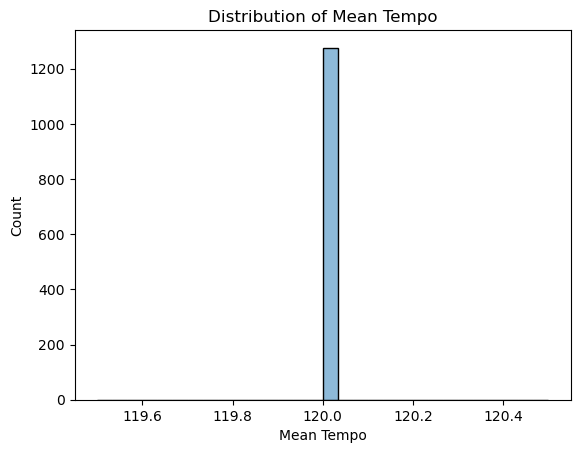

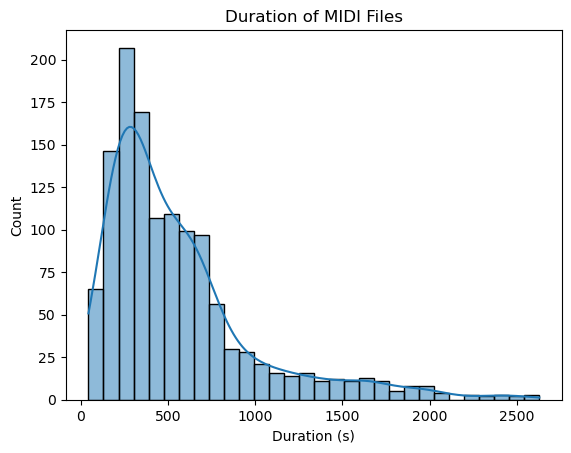

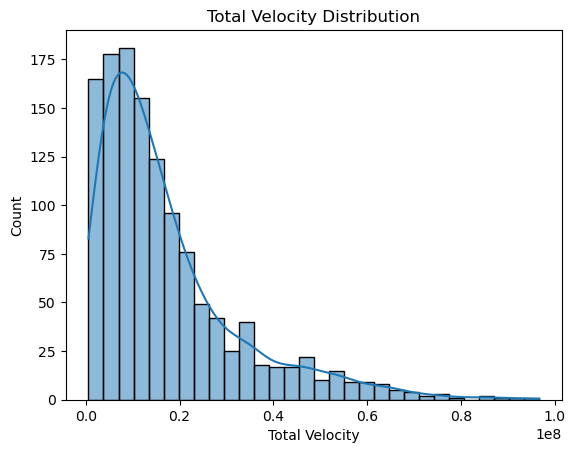

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tempo distribution
sns.histplot(df['mean_tempo'], bins=30, kde=True)
plt.title('Distribution of Mean Tempo')
plt.xlabel('Mean Tempo')
plt.ylabel('Count')
plt.show()

# Duration
sns.histplot(df['duration_s'], bins=30, kde=True)
plt.title('Duration of MIDI Files')
plt.xlabel('Duration (s)')
plt.ylabel('Count')
plt.show()

# Total Velocity
sns.histplot(df['total_velocity'], bins=30, kde=True)
plt.title('Total Velocity Distribution')
plt.xlabel('Total Velocity')
plt.show()


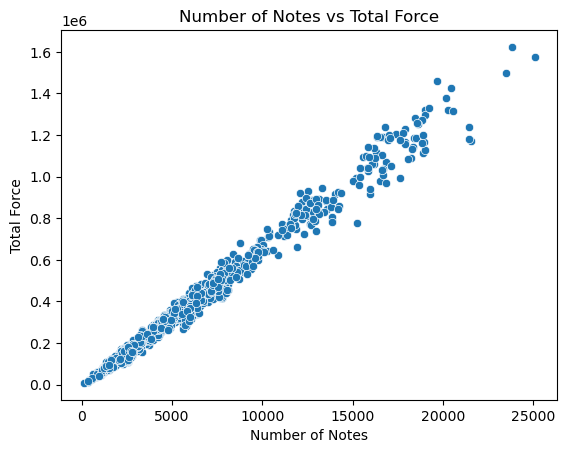

In [22]:
# Force vs Number of Notes
sns.scatterplot(x='n_notes', y='total_force', data=df)
plt.title('Number of Notes vs Total Force')
plt.xlabel('Number of Notes')
plt.ylabel('Total Force')
plt.show()


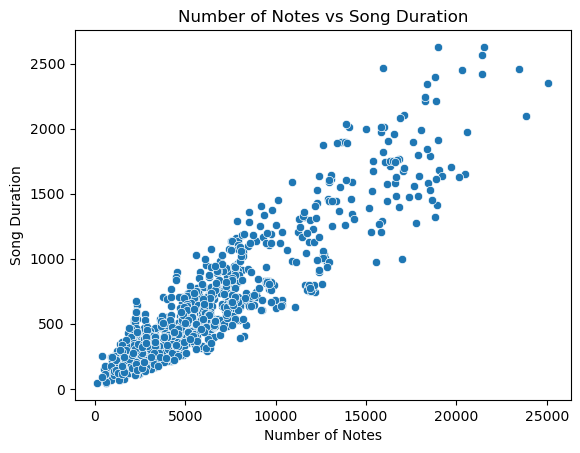

In [25]:
# Duration vs Number of Notes
sns.scatterplot(x='n_notes', y='duration_s', data=df)
plt.title('Number of Notes vs Song Duration')
plt.xlabel('Number of Notes')
plt.ylabel('Song Duration')
plt.show()

In [ ]:
# Duration vs Number of Notes
sns.scatterplot(x='n_notes', y='duration_s', data=df)
plt.title('Number of Notes vs Total Force')
plt.xlabel('Number of Notes')
plt.ylabel('Total Force')
plt.show()

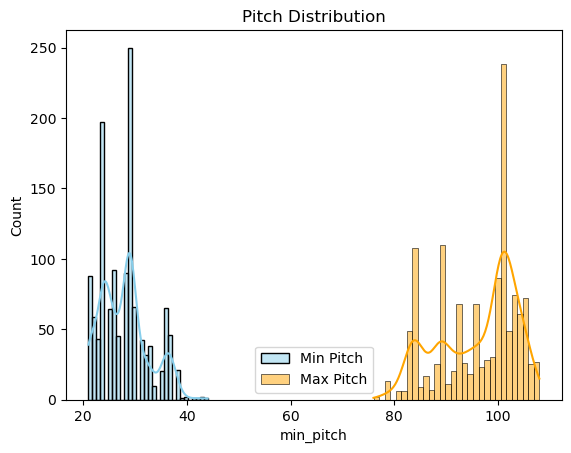

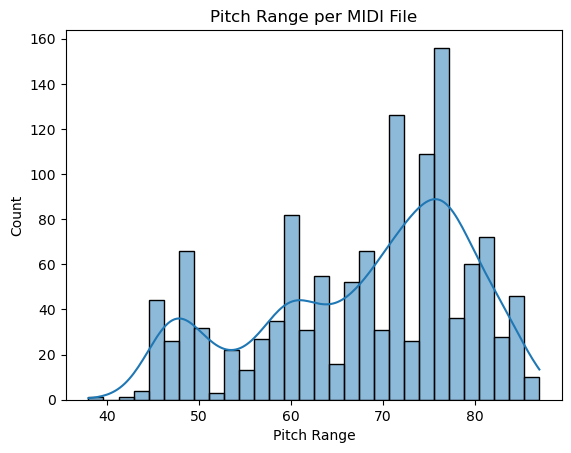

In [26]:
# Min vs Max Pitch
sns.histplot(df['min_pitch'], bins=30, kde=True, color='skyblue', label='Min Pitch')
sns.histplot(df['max_pitch'], bins=30, kde=True, color='orange', label='Max Pitch')
plt.legend()
plt.title('Pitch Distribution')
plt.show()

# Pitch Range
df['pitch_range'] = df['max_pitch'] - df['min_pitch']
sns.histplot(df['pitch_range'], bins=30, kde=True)
plt.title('Pitch Range per MIDI File')
plt.xlabel('Pitch Range')
plt.show()


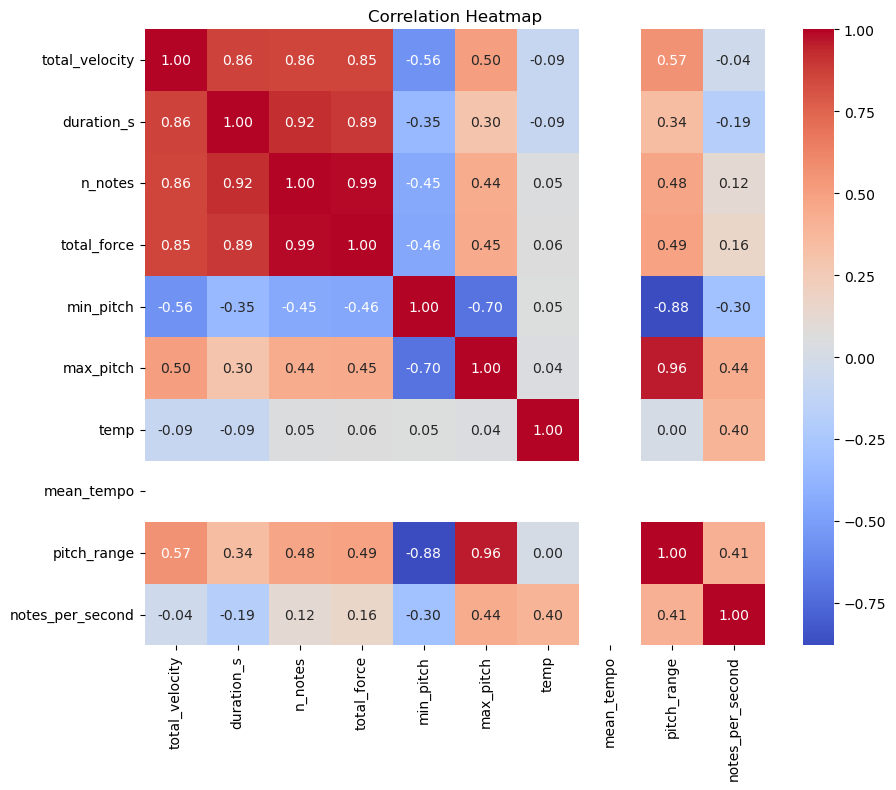

In [28]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

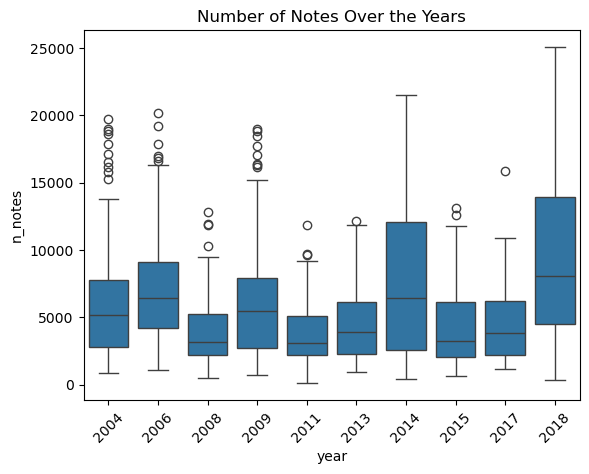

In [29]:
df['year'] = df['file'].str.extract(r'(\d{4})').astype(int)

# Notes over the years
sns.boxplot(x='year', y='n_notes', data=df)
plt.title('Number of Notes Over the Years')
plt.xticks(rotation=45)
plt.show()